1\. **Pandas DataFrame**

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a pair of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every `x` BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [1]:
# If haven't downloaded it yet, please get the data file with wget
#!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ./data/

1\. Create a Pandas DataFrame reading N rows of the `data/data_000637.txt` dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k (check the documentation).

In [2]:
import pandas as pd
file_path = './data/data_000637.txt'
N = 15000 
column_names = ['HEAD', 'FPGA', 'TDC_CHANNEL', 'ORBIT_CNT', 'BX_COUNTER', 'TDC_MEAS']
df = pd.read_csv(file_path,  nrows=N)
print(df)


       HEAD  FPGA  TDC_CHANNEL   ORBIT_CNT  BX_COUNTER  TDC_MEAS
0         1     0          123  3869200167        2374        26
1         1     0          124  3869200167        2374        27
2         1     0           63  3869200167        2553        28
3         1     0           64  3869200167        2558        19
4         1     0           64  3869200167        2760        25
...     ...   ...          ...         ...         ...       ...
14995     1     1            4  3869200316        3399         9
14996     1     1           17  3869200316        3400        15
14997     1     1           10  3869200316        3530        16
14998     1     1            8  3869200316        3533        18
14999     1     0          139  3869200316        3539         0

[15000 rows x 6 columns]


2\. Estimate the number of BX in a ORBIT (the value `x`).

*Hint*: check when the BX counter reaches the maximum value before being reset to 0.

In [3]:
max_bx = df['BX_COUNTER'].max()

reset_indices = df[df['BX_COUNTER'] == 0].index

if len(reset_indices) >= 2:    
    bx_per_orbit = reset_indices[1] - reset_indices[0]
    print(f"Maximum BX_COUNTER value: {max_bx}")
    print(f"Estimated number of BX in an ORBIT (x): {bx_per_orbit}")
else:
    print("No BX_COUNTER reset to 0 found in the dataset.")

Maximum BX_COUNTER value: 3563
Estimated number of BX in an ORBIT (x): 5106


3\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information) since the beginning of the data acquisition, and convert the new column to a Time Series.

*Hint:* introduce an offset to the absolute time such that the start of the data acquisition (i.e. the first entry) is zero.

In [4]:
df['Absolute_Time_ns'] = (((df['ORBIT_CNT'] * max_bx + df['BX_COUNTER']) * 25 / 30 + df['TDC_MEAS']) * 1e9)

start_time_offset = df['Absolute_Time_ns'].min()
df['Absolute_Time_ns'] -= start_time_offset
df['Time_Series'] = pd.to_datetime(df['Absolute_Time_ns'], unit='ns')

print(df[['ORBIT_CNT', 'BX_COUNTER', 'TDC_MEAS', 'Absolute_Time_ns', 'Time_Series']])




        ORBIT_CNT  BX_COUNTER  TDC_MEAS  Absolute_Time_ns  \
0      3869200167        2374        26      0.000000e+00   
1      3869200167        2374        27      1.000342e+09   
2      3869200167        2553        28      1.511648e+11   
3      3869200167        2558        19      1.463309e+11   
4      3869200167        2760        25      3.206650e+11   
...           ...         ...       ...               ...   
14995  3869200316        3399         9      4.432430e+14   
14996  3869200316        3400        15      4.432498e+14   
14997  3869200316        3530        16      4.433592e+14   
14998  3869200316        3533        18      4.433637e+14   
14999  3869200316        3539         0      4.433507e+14   

                        Time_Series  
0     1970-01-01 00:00:00.000000000  
1     1970-01-01 00:00:01.000341504  
2     1970-01-01 00:02:31.164813312  
3     1970-01-01 00:02:26.330877952  
4     1970-01-01 00:05:20.665026560  
...                             ...  
1

4\. Find out the duration of the data taking in hours, minutes and seconds, by using the features of the Time Series. Perform this check reading the whole dataset.

In [5]:
df['ABSOULTE_TIME'] = pd.to_timedelta(df['Absolute_Time_ns'], unit='ns')
df.head(4)

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,Absolute_Time_ns,Time_Series,ABSOULTE_TIME
0,1,0,123,3869200167,2374,26,0.000000e+00,1970-01-01 00:00:00.000000000,0 days 00:00:00
1,1,0,124,3869200167,2374,27,1.000342e+09,1970-01-01 00:00:01.000341504,0 days 00:00:01.000341504
2,1,0,63,3869200167,2553,28,1.511648e+11,1970-01-01 00:02:31.164813312,0 days 00:02:31.164813312
3,1,0,64,3869200167,2558,19,1.463309e+11,1970-01-01 00:02:26.330877952,0 days 00:02:26.330877952


5\. Use the `.groupby()` method to find out the noisy channels, i.e. the TDC channels with most counts (print to screen the top 3 and the corresponding counts)

In [6]:
channel_counts = df.groupby('TDC_CHANNEL').size()

top_3channels = channel_counts.sort_values(ascending=False).head(3)

print("Top 3 Noisy Channels:")
print(top_3channels)

Top 3 Noisy Channels:
TDC_CHANNEL
139    1268
64      752
63      749
dtype: int64


6\. Count the number of non-empty orbits (i.e. the number of orbits with at least one hit).

In [7]:
non_empty_orbits_count = df['ORBIT_CNT'].nunique()

print("Number of Non-Empty Orbits:", non_empty_orbits_count)

Number of Non-Empty Orbits: 150


In [8]:
df.groupby("ORBIT_CNT").count().shape[0]

150

7\. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139.

In [9]:
df_channel_139 = df[df['TDC_CHANNEL'] == 139]

unique_orbits_count_channel_139 = df_channel_139['ORBIT_CNT'].nunique()

print("Number of Unique Orbits with TDC_CHANNEL=139:", unique_orbits_count_channel_139)

Number of Unique Orbits with TDC_CHANNEL=139: 150


8\. Create two Series (one for each FPGA) that have the TDC channel as index, and the number of counts for the corresponding TDC channel as values.

In [10]:

fpga_counts = df.groupby(['FPGA', 'TDC_CHANNEL']).size()

fpga_0_series = fpga_counts.loc[0] if 0 in fpga_counts.index.levels[0] else pd.Series()

fpga_1_series = fpga_counts.loc[1] if 1 in fpga_counts.index.levels[0] else pd.Series()


print("FPGA 0 Series:")
print(fpga_0_series)

print("\nFPGA 1 Series:")
print(fpga_1_series)

FPGA 0 Series:
TDC_CHANNEL
1        8
2       16
3       16
4       19
5       19
      ... 
121     63
122     71
123    202
124    193
139    879
Length: 117, dtype: int64

FPGA 1 Series:
TDC_CHANNEL
1      338
2      363
3      277
4      290
5      189
      ... 
125      6
126      7
127     16
128     18
139    389
Length: 124, dtype: int64


9\. **Optional:** Create two histograms (one for each FPGA) that show the number of counts for each TDC channel.

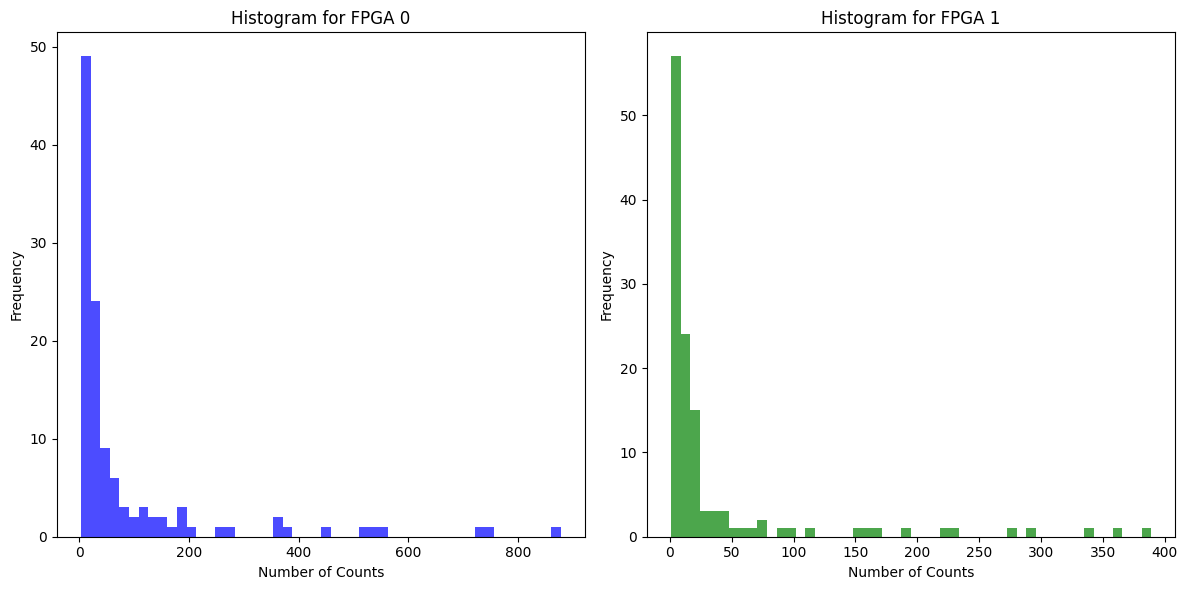

In [11]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(fpga_0_series, bins=50, color='blue', alpha=0.7)
plt.title('Histogram for FPGA 0')
plt.xlabel('Number of Counts')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(fpga_1_series, bins=50, color='green', alpha=0.7)
plt.title('Histogram for FPGA 1')
plt.xlabel('Number of Counts')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()